In [1]:
from src import qdpm
from qutip import identity, Qobj, basis
from qutip.qip.operations import rx, ry
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import src.NQubitSystem_qutip as NQS_QT
import src.AdvancedWaveforms_JH as wfm_adv

from src.pulseGenFuncs import Paths
%matplotlib inline
from src.optimHelperFunctions import NielsenFidelity, gate
import torch
from copy import deepcopy

In [2]:
def gateData(basePath, date):
    qSys = NQS_QT.NQubitSystem_QT(basePath / 'G0' / 'results' / 'gate' / date)
    qSys.numLevels = 2
    gates = wfm_adv.loadGates(qSys, basePath / 'gates.json')
    U_vals = [NQS_QT.unitaryFromOpList(qSys.gateExpSliceToUnitaryOpList(gates[g_i])) for g_i in gateIndices]
    G_T = [sum([pulse.duration for pulse in gates[g_i].opList[0].pulseList]) for g_i in gateIndices]
    G_T_theory = np.array(G_T)/(np.pi/(qSys.twoQubitValues[0][1]['ZZ']*2*np.pi))
    return {'U_vals':U_vals,
            'G_T':G_T,
            'G_T_theory': G_T_theory}
def getTomos(basePath, date, gateIndices, gateDataVals):
    preparation = [identity(2),
                   rx(np.pi),
                   ry(np.pi/2),
                   ry(-np.pi/2),
                   rx(-np.pi/2),
                   rx(np.pi/2)]
    rotation = [identity(2),
                rx(-np.pi/2),
                ry(np.pi/2)]
    init_state = [basis(2,0), basis(2, 0)]

    studyPath_I = Path('.') / 'ExpData' / 'ProcessTomographyTest' / 'id'
    paths_I = Paths(studyPath_I)

    R_I = qdpm.ProcessTomography(qdpm.Experiment(paths_I.resultsPath(date)), init_state, preparation, rotation)._R_mle

    tomos= list()

    for g_i in gateIndices:
        studyPath = Paths(basePath / ('G'+str(g_i)))
        tomo = qdpm.ProcessTomography(qdpm.Experiment(studyPath.resultsPath(date)), init_state, preparation, rotation)
        U = gateDataVals['U_vals'][g_i]
        R_U = tomo._R_mle
        R_spamFree = qdpm.R_SPAMfree(U, R_U, R_I)
        tomo._R_mle = R_spamFree.astype('float64')
        tomos.append(tomo)
    return tomos
def IFs(gateName, basePath, date, gateIndices, U_vals, tomos):
    qSys = NQS_QT.NQubitSystem_QT(basePath / 'G0' / 'results' / 'gate' / date)
    qSys.numLevels = 2

    TheoryGate = gate(qSys, gateName).numpy()

    G_IF_Exp_Theory = list()
    G_IF_Theory_TheoryGate = list()
    G_IF_Exp_TheoryGate = list()
    for g_i in gateIndices:
        tomo=tomos[g_i]

        G_IF_Exp_Theory.append(1-tomo.fidelity(Qobj(U_vals[g_i], dims=[[2,2],[2,2]])))
        G_IF_Theory_TheoryGate.append(1-NielsenFidelity(qSys.N, torch.tensor(U_vals[g_i], dtype=torch.cdouble), torch.tensor(TheoryGate, dtype=torch.cdouble)).item())
        G_IF_Exp_TheoryGate.append(1-tomo.fidelity(Qobj(TheoryGate, dims=[[2,2],[2,2]])))
    return {'G_IF_Exp_Theory':G_IF_Exp_Theory,
            'G_IF_Theory_TheoryGate':G_IF_Theory_TheoryGate,
            'G_IF_Exp_TheoryGate':G_IF_Exp_TheoryGate}

        # if g_i == 15:
        #     tomo.plot()
        #     plt.savefig('CNOT75hist_exp.png', dpi=500)

    #         tomo.plot_theory(Qobj(TheoryGate, dims=[[2,2],[2,2]]))
    #         plt.savefig('CNOT75hist_theory.png', dpi=500)
def fidelityCurve(gateName, rabiStrengthMHz, gateDataVals, IFdict):
    plt.plot(gateDataVals['G_T_theory'], IFdict['G_IF_Exp_Theory'], 'bo-', label='IF Exp/Theory')
    plt.plot(gateDataVals['G_T_theory'], IFdict['G_IF_Theory_TheoryGate'], 'go-', label='IF Theory/'+gateName)
    plt.plot(gateDataVals['G_T_theory'], IFdict['G_IF_Exp_TheoryGate'], 'ro-', label='IF Exp/'+gateName)

    plt.legend()
    plt.title(gateName+' Q0-XY Q1-XY square 4segs $\Omega=$'+str(rabiStrengthMHz)+'MHz')
    plt.xlabel('Gate T (units of pi/gz)')
    plt.ylabel('Infidelity')
    plt.show()
def fidelityCurve_noise(gateName, rabiStrengthMHz, gateDataVals, IFdict, noiseDictIFs):
    plt.errorbar(x=gateDataVals['G_T_theory'],
                 y=noiseDictIFs['G_IF_Exp_Theory_Mean'],
                 yerr=noiseDictIFs['G_IF_Exp_Theory_STD'],
                 fmt='b-', label='IF Exp/Theory')
    plt.errorbar(x=gateDataVals['G_T_theory'],
                 y=noiseDictIFs['G_IF_Exp_TheoryGate_Mean'],
                 yerr=noiseDictIFs['G_IF_Exp_TheoryGate_STD'],
                 fmt='r-', label='IF Exp/'+str(gateName))
    plt.plot(gateDataVals['G_T_theory'], IFdict['G_IF_Theory_TheoryGate'], 'go-', label='IF Theory/CNOT')

    plt.legend()
    plt.title(gateName+' Q0-XY Q1-XY square 4segs $\Omega=$'+str(rabiStrengthMHz)+'MHz')
    plt.xlabel('Gate T (units of pi/gz)')
    plt.ylabel('Infidelity')
    plt.show()
def saveIFs(gateName, rabiStrengthMHz, gateDataVals, IFdict):
    numGates = len(gateDataVals['G_T_theory'])
    np.savetxt(gateName+'_'+str(rabiStrengthMHz)+'MHz_expData_theory.csv',
               np.array([[gateDataVals['G_T_theory'][i], IFdict['G_IF_Theory_TheoryGate'][i]] for i in range(numGates)]), delimiter=",")
    np.savetxt(gateName+'_'+str(rabiStrengthMHz)+'MHz_expData_exp.csv',
               np.array([[gateDataVals['G_T_theory'][i], np.real(IFdict['G_IF_Exp_TheoryGate'][i])] for i in range(numGates)]), delimiter=",")
    np.savetxt(gateName+'_'+str(rabiStrengthMHz)+'MHz_expData_expVstheory.csv',
               np.array([[gateDataVals['G_T_theory'][i], np.real(IFdict['G_IF_Exp_Theory'][i])] for i in range(numGates)]), delimiter=",")
def gaussianNoise(gateName, basePath, date, gateIndices, U_vals, tomos):
    np.random.seed(0)
    numNoiseTrials = 10
    N = 500
    G_IF_Exp_Theory_Mean = list()
    G_IF_Exp_Theory_STD = list()
    G_IF_Exp_TheoryGate_Mean = list()
    G_IF_Exp_TheoryGate_STD = list()
    for g_i in gateIndices:
        tomoArray = list()
        for noiseIndex in range(numNoiseTrials):
            tomo_noise = deepcopy(tomos[g_i])
            noiseArray = 1/np.sqrt(N)*np.array([np.random.normal(0,1) for _ in range(16 * 16)]).reshape(16, 16)
            tomo_noise._R_mle += noiseArray
            tomoArray.append(tomo_noise)
        IFdict = IFs(gateName, basePath, date, range(numNoiseTrials), [U_vals[g_i]]*numNoiseTrials, tomoArray)

        G_IF_Exp_Theory_Mean.append(np.mean(np.array(IFdict['G_IF_Exp_Theory'])))
        G_IF_Exp_Theory_STD.append(np.std(np.array(IFdict['G_IF_Exp_Theory'])))

        G_IF_Exp_TheoryGate_Mean.append(np.mean(np.array(IFdict['G_IF_Exp_TheoryGate'])))
        G_IF_Exp_TheoryGate_STD.append(np.std(np.array(IFdict['G_IF_Exp_TheoryGate'])))
    return {'G_IF_Exp_Theory_Mean': G_IF_Exp_Theory_Mean,
            'G_IF_Exp_Theory_STD': G_IF_Exp_Theory_STD,
            'G_IF_Exp_TheoryGate_Mean': G_IF_Exp_TheoryGate_Mean,
            'G_IF_Exp_TheoryGate_STD': G_IF_Exp_TheoryGate_STD}

In [3]:
gateName = 'CNOT'
rabiStrengthMHz = 7.5
gateIndices = range(20)

In [4]:
if gateName == 'CNOT':
    date = '2022-03-11_0'
    if rabiStrengthMHz == 7.5:
        basePath = Path('.') / 'ExpData' / gateName / (str(rabiStrengthMHz)+'MHz') / '20Points' / 'gateData_allRepeats'
    elif rabiStrengthMHz == 12:
        basePath = Path('.') / 'ExpData' / gateName / (str(rabiStrengthMHz)+'MHz') / '20Points'

gateDataVals = gateData(basePath, date)

In [5]:
tomos = getTomos(basePath, date, gateIndices, gateDataVals)

C:\Users\joela\AppData\Local\Temp\ipykernel_16972\3087160807.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  tomo._R_mle = R_spamFree.astype('float64')


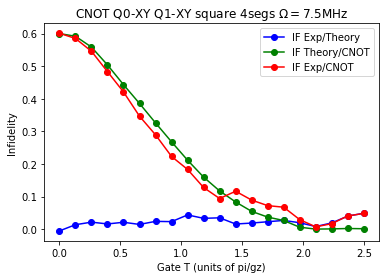

In [6]:
IFdict = IFs(gateName, basePath, date, gateIndices, gateDataVals['U_vals'], tomos)
fidelityCurve(gateName, rabiStrengthMHz, gateDataVals, IFdict)

In [7]:
saveIFs(gateName, rabiStrengthMHz, gateDataVals, IFdict)

In [8]:
noiseDictIFs = gaussianNoise(gateName, basePath, date, gateIndices, gateDataVals['U_vals'], tomos)

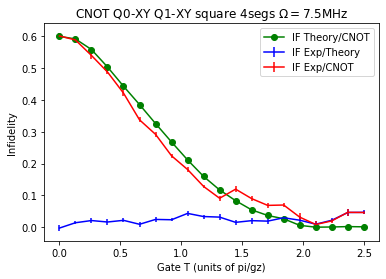

In [9]:
fidelityCurve_noise(gateName, rabiStrengthMHz, gateDataVals, IFdict, noiseDictIFs)

# Gaussian Noise (other)

In [10]:
# preparation = [identity(2),
#                    rx(np.pi),
#                    ry(np.pi/2),
#                    ry(-np.pi/2),
#                    rx(-np.pi/2),
#                    rx(np.pi/2)]
# rotation = [identity(2),
#             rx(-np.pi/2),
#             ry(np.pi/2)]
# init_state = [basis(2,0), basis(2, 0)]

In [11]:
# qSys = NQS_QT.NQubitSystem_QT(basePath / 'G0' / 'results' / 'gate' / date)
# qSys.numLevels = 2
#
# np.random.seed(0)
# numNoiseTrials = 10
# N = 500
# gateDataPath = basePath / 'gates.json'
#
# gates = wfm_adv.loadGates(qSys, gateDataPath)
# numGates = len(gates)
#
# TheoryGate = gate(qSys, 'CNOT').numpy()
#
# studyPath_I = Path('.') / 'ExpData' / 'ProcessTomographyTest' / 'id'
# paths_I = Paths(studyPath_I)
#
# R_I = qdpm.ProcessTomography(qdpm.Experiment(paths_I.resultsPath('2022-03-11_0')), init_state, preparation, rotation)._R_mle
#
# G_IF_Exp_Theory = list()
# G_IF_Theory_TheoryGate = list()
# G_IF_Exp_TheoryGate = list()
#
# G_IF_Exp_Theory_STD = list()
# G_IF_Exp_TheoryGate_STD = list()
#
# G_T = list()
# for g_i in range(numGates):
#     studyPaths = Paths(basePath / ('G'+str(g_i)))
#
#     gateExpSlice = gates[g_i]
#     G_T.append(sum([pulse.duration for pulse in gateExpSlice.opList[0].pulseList]))
#
#     U = NQS_QT.unitaryFromOpList(qSys.gateExpSliceToUnitaryOpList(gateExpSlice))
#     U_qt = Qobj(U, dims=[[2,2],[2,2]])
#     G_IF_Theory_TheoryGate.append(1-NielsenFidelity(qSys.N, torch.tensor(U, dtype=torch.cdouble), torch.tensor(TheoryGate, dtype=torch.cdouble)).item())
#
#     tomo = qdpm.ProcessTomography(qdpm.Experiment(studyPaths.resultsPath('2022-03-11_0')), init_state, preparation, rotation)
#     tomo_original = deepcopy(tomo)
#
#     G_IF_Exp_Theory_Noise = list()
#     G_IF_Exp_TheoryGate_Noise = list()
#     for noiseIndex in range(numNoiseTrials):
#         R_U = tomo_original._R_mle
#         R_spamFree = qdpm.R_SPAMfree(U, R_U, R_I)
#         tomo._R_mle = R_spamFree.astype('float64')
#         noiseArray = 1/np.sqrt(N)*np.array([np.random.normal(0,1) for i in range(16*16)]).reshape(16,16)
#         tomo._R_mle += noiseArray
#
#         G_IF_Exp_Theory_Noise.append(1-tomo.fidelity(U_qt))
#         G_IF_Exp_TheoryGate_Noise.append(1-tomo.fidelity(Qobj(TheoryGate, dims=[[2,2],[2,2]])))
#
#     G_IF_Exp_Theory_STD.append(np.std(np.array(G_IF_Exp_Theory_Noise)))
#     G_IF_Exp_TheoryGate_STD.append(np.std(np.array(G_IF_Exp_TheoryGate_Noise)))
#
#     G_IF_Exp_Theory.append(np.mean(np.array(G_IF_Exp_Theory_Noise)))
#     G_IF_Exp_TheoryGate.append(np.mean(np.array(G_IF_Exp_TheoryGate_Noise)))
#
# G_T_theory = np.array(G_T)/(np.pi/(qSys.twoQubitValues[0][1]['ZZ']*2*np.pi))
#
# plt.errorbar(x=G_T_theory, y=G_IF_Exp_Theory, fmt='bo-', label='IF Exp/Theory', yerr=G_IF_Exp_Theory_STD)
# plt.plot(G_T_theory, G_IF_Theory_TheoryGate, 'go-', label='IF Theory/CNOT')
# plt.errorbar(x=G_T_theory, y=G_IF_Exp_TheoryGate, fmt='ro-', label='IF Exp/CNOT', yerr=G_IF_Exp_TheoryGate_STD)
#
# plt.legend()
# # plt.legend(['IF Theory/CNOT', 'IF Exp/CNOT'])
# plt.title('CNOT Q0-XY Q1-XY square 4segs $\Omega=7.5MHz$ ')
# plt.xlabel('Gate T (units of pi/gz)')
# plt.ylabel('Infidelity')
# plt.show()